In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

In [2]:
compose = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5])]
                            )

In [3]:
data = FashionMNIST(root='data',train=True, transform=compose,  download=True)

In [4]:
print(data.class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [5]:
data.data.size()

torch.Size([60000, 28, 28])

In [6]:
batch_size= 100
data_loader = DataLoader(data, batch_size= 100)

In [7]:
sample = next(iter(data_loader))

In [8]:
batch, label = next(iter(data_loader))

In [9]:
batch.shape

torch.Size([100, 1, 28, 28])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

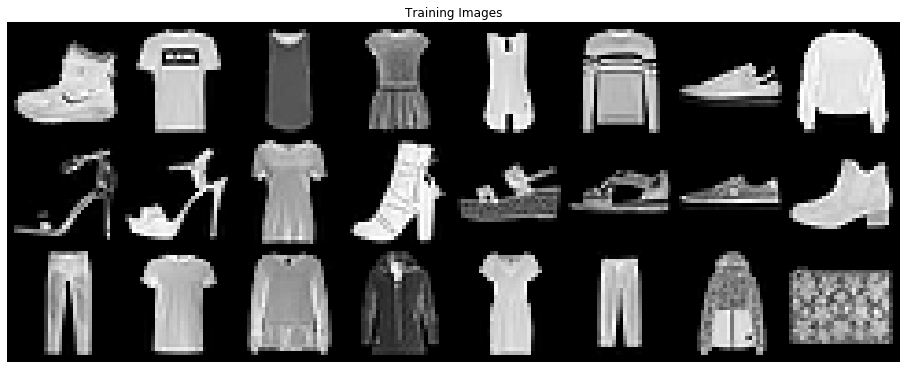

In [12]:
plt.figure(figsize=(16,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:24], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_
G = Generator().to(device)

In [14]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_
D = Discriminator().to(device)

In [15]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [16]:
n_noise = 100

In [17]:
def get_sample_image(model, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(device)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [18]:
D_labels = torch.ones(batch_size, 1).to(device) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(device) # Discriminator Label to fak

In [19]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [20]:
if not os.path.exists('samples/vanilla_gan'):
    os.makedirs('samples/vanilla_gan')

In [21]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(device)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(device)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(device)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch+1, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            plt.imsave('samples/vanilla_gan/{}_step{}.jpg'.format('V_GAN', str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 1/50, Step: 0, D Loss: 1.3806877136230469, G Loss: 0.6960777044296265
Epoch: 1/50, Step: 500, D Loss: 1.2582765817642212, G Loss: 1.4710776805877686
Epoch: 2/50, Step: 1000, D Loss: 1.253075361251831, G Loss: 1.1829156875610352
Epoch: 3/50, Step: 1500, D Loss: 1.2688543796539307, G Loss: 0.69783616065979
Epoch: 4/50, Step: 2000, D Loss: 1.41563081741333, G Loss: 0.9669399857521057
Epoch: 5/50, Step: 2500, D Loss: 1.223233699798584, G Loss: 0.9667336940765381
Epoch: 6/50, Step: 3000, D Loss: 1.302944540977478, G Loss: 0.8126382231712341
Epoch: 6/50, Step: 3500, D Loss: 1.2845029830932617, G Loss: 0.9373986124992371
Epoch: 7/50, Step: 4000, D Loss: 1.2949185371398926, G Loss: 0.8341405391693115
Epoch: 8/50, Step: 4500, D Loss: 1.296848177909851, G Loss: 0.7447919249534607
Epoch: 9/50, Step: 5000, D Loss: 1.3215053081512451, G Loss: 0.8757780194282532
Epoch: 10/50, Step: 5500, D Loss: 1.3614633083343506, G Loss: 0.9027135372161865
Epoch: 11/50, Step: 6000, D Loss: 1.267822742462158

In [22]:
img = get_sample_image(G, 100)

(-0.5, 279.5, 279.5, -0.5)

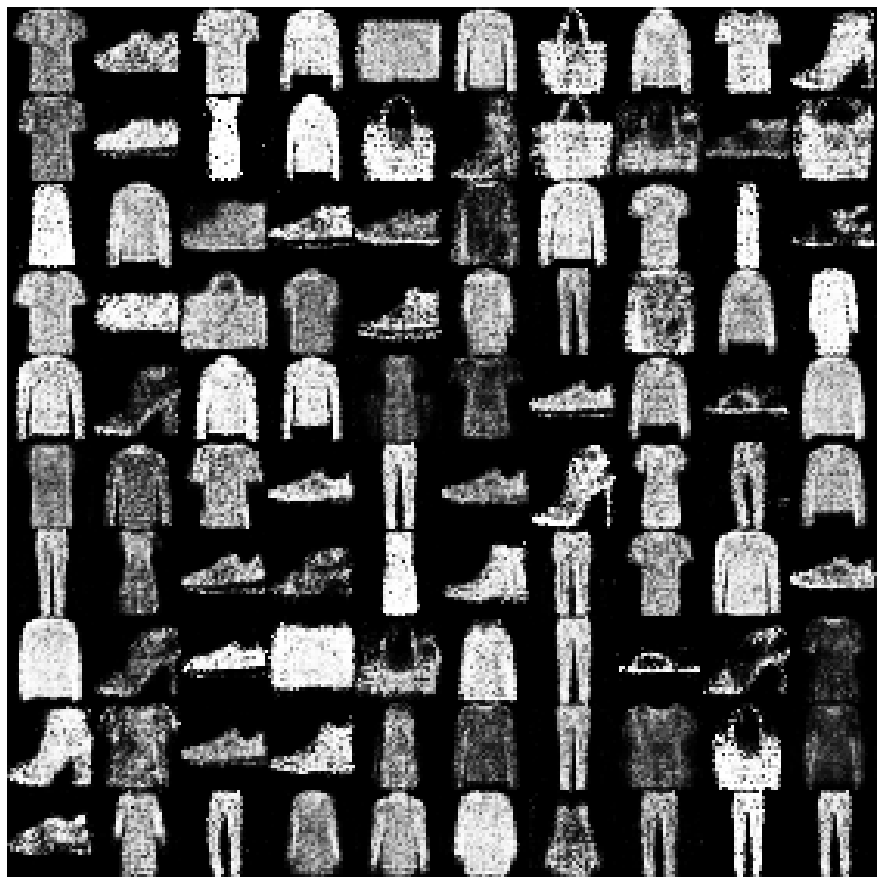

In [23]:
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray')
plt.axis('off')